# P7_04_FEATURE SELECTION ET HYPERPARAMETRES
Nous séléctionnons le modèle LIGHT GRADIENT BOOSTING avec la méthode de rééquilibrage undersampling car c'est celui qui a la meilleure métrique AUC : 0.667  
Le modèle Light Gradient Boosting Machine fonctionne avec des valeurs manquantes et est invariant à l'échelle. Les données sans preprocessing peuvent donc être utilisées.

# 1-MISE EN PLACE

## 1-1 IMPORT

In [1]:
import math
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import random
import gc
import os

In [2]:
from platform import python_version
python_version()

'3.9.7'

In [3]:
!pip install lightgbm

In [4]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

## 1-2 CHARGEMENT DES DONNEES

In [5]:
os.getcwd()

'C:\\Users\\marie\\OPC\\P7'

In [6]:
app_df = pd.read_csv("C:\\Users\\marie\\OPC\\P7/app_train_features.csv")


In [7]:
app_df.head(1)

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
0,0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,...,19.0,9251.775,9251.775,9251.775,175783.73,19.0,219625.7,219625.7,219625.7,4172888.2


## 1-3 SUPPRESSION DES FEATURES NON PERTINENTES

In [8]:
# Let's drop the features that are not useful for the prediction
cols_todrop =["FLAG_MOBIL", "CODE_GENDER_M", "CODE_GENDER_F", "CODE_GENDER_XNA", 'Unnamed: 0']
app = app_df.drop(columns=cols_todrop)


## 1-4 SAMPLING

In [9]:
# Afin de travailler plus vite je fais un échantillinage
data_sample = app.sample(10000, random_state=42)

In [10]:
data_sample.to_csv('data_sample.csv')

## 1-5 SEPARATION DES DONNEES
Nous allons transformer les données pour que nos modèles puissent les exploiter au mieux. Afin d'éviter la "fuite d'information" entre le jeu de données d'entraînement et de test, nous allons maintenant séparer notre jeu de données en deux. Les transformations seront apprises uniquement sur le jeu d'entraînement, mais appliquées aux deux jeux de données (entraînement et test).

In [11]:
# Given data
X = data_sample.drop(["TARGET"], axis=1)
# Data to predict
y = data_sample["TARGET"]

# Let's split the whole dataset into a training set (80% of data) and a test set (20% of data)
# The dataset will be split in a stratified way, in order to have a good distribution of the target variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [12]:
# Let's split the whole dataset into a training set (80% of data) and a test set (20% of data)
# The dataset will be split in a stratified way, in order to have a good distribution of the target variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

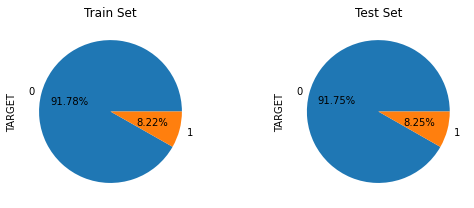

In [13]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(8,4))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set')
y_test.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Test Set')
fig.subplots_adjust(wspace=0.5)

## 1-6 CRÉATION MÉTRIQUE - FONCTION DE COÛT PROPRES
Dans notre cas, il est important de pénaliser les faux positifs bien plus que les faux négatifs.

Nous allons donc créer une fonction de coût - métrique spécifique à notre problème de classification qui doit permettre de minimiser le risque pour la banque.

Utiliser une fonction coût métier (par exemple, un faux négatif coûte 10 fois plus qu'un faux positif) dans la détermination du seuil de probabilité qui distingue les négatifs des positifs : trouver le minimum de ce coût en fonction du seuil. Voir si https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html est pertinent, sinon coder une fonction personnalisée qui prend comme arguments y_true et et y_pred (calculé en fonction d'un seuil) et qui rend un coût à partir de la matrice de confusion. 

In [14]:
def bank_score(y_true, y_pred):
    
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()
    N = TN + FP    # total negatives cases
    P = TP + FN    # total positives cases
    
    # We set the bank's gain and loss for each case
    FN_value = -10   # The loan is granted but the customer defaults (Type-II Error) 
    TN_value = 1     # The loan is reimbursed
    TP_value = 0     # The loan is (rightly) refused
    FP_value = -1    # Loan is refused by mistake (Type-I Error)

    # calculate total gains
    gain = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
    
    # best score : all observations are correctly predicted
    best = N*TN_value + P*TP_value 

    # baseline : all observations are predicted = 0
    baseline = N*TN_value + P*FN_value 
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain - baseline) / (best - baseline)
    
    return score

In [15]:
custom_score = make_scorer(bank_score)

In [16]:
make_scorer

<function sklearn.metrics._scorer.make_scorer(score_func, *, greater_is_better=True, needs_proba=False, needs_threshold=False, **kwargs)>

## 1-7 IMPUTATION DES VALEURS MANQUANTES

In [17]:
for col in X_train.columns:
    m = X_train.loc[X_train[col] != np.inf, col].max()
    X_train[col].replace(np.inf,m,inplace=True)
    X_test[col].replace(np.inf,m,inplace=True)

for col in X_train.columns:
    m = X_train.loc[X_train[col] != -np.inf, col].min()
    X_train[col].replace(-np.inf,m,inplace=True)
    X_test[col].replace(-np.inf,m,inplace=True)


## 1-8 STRATÉGIE DE RÉÉQUILIBRAGE : UNDERSAMPLING

In [18]:
rus = RandomUnderSampler(random_state=6)

In [19]:
# The standard datazset
xtrain_us, ytrain_us = rus.fit_resample(X_train, y_train)

In [20]:
X_train.shape

(8000, 1775)

In [21]:
xtrain_us.shape

(1316, 1775)

In [22]:
y_train.sum()

658

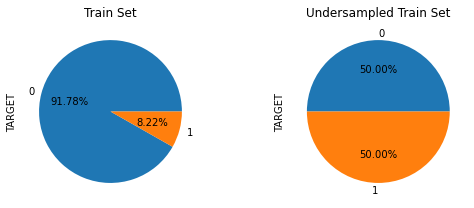

In [23]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(8,4))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set')
ytrain_us.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Undersampled Train Set')
fig.subplots_adjust(wspace=0.5)

In [24]:
print("Le jeu de données undersampled contient {} observations, c'est-à-dire {} de moins que le jeu de données standard, soit {:1.2f}% de moins."\
      .format(len(ytrain_us), len(y_train)-len(ytrain_us), (len(y_train)-len(ytrain_us))/len(y_train)*100))

Le jeu de données undersampled contient 1316 observations, c'est-à-dire 6684 de moins que le jeu de données standard, soit 83.55% de moins.


# 2- SELECTION DES FEATURES

In [25]:
results = pd.DataFrame(columns=["Features","ROC AUC score Test"])

## 2-1 BASELINE: UNDERSAMPLING SANS SELECTION DE FEATURES

In [26]:
xtrain_us_model = xtrain_us.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [27]:
X_test_model = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [28]:
baseline_model = lgb.LGBMClassifier(n_estimators=100, 
                                objective = 'binary', 
                                learning_rate = 0.05, 
                                reg_alpha = 0.1, 
                                reg_lambda = 0.1, 
                                subsample = 0.8, 
                                    n_jobs = -1, 
                                random_state = 42)

In [29]:
baseline_model.fit(xtrain_us_model, ytrain_us)

LGBMClassifier(learning_rate=0.05, objective='binary', random_state=42,
               reg_alpha=0.1, reg_lambda=0.1, subsample=0.8)

In [30]:
y_pred = baseline_model.predict(X_test_model)

In [31]:
xtrain1 = xtrain_us_model

In [32]:
ytrain1 = ytrain_us

In [33]:
results.loc[len(results)] = ["All features", 
                            round(roc_auc_score(y_test, y_pred), 3)]

In [34]:
results

,Features,ROC AUC score Test
0,All features,0.664


## 2.2 SUPPRESSION DES FEATURES COLINÉAIRES
Pour chaque paire de features colinéaires à plus de 90% (coefficient de spearman), l'une des 2 features est supprimée.

In [35]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = xtrain_us_model.corr("spearman").abs()
corr_matrix.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
SK_ID_CURR,1.000000,0.040307,0.040316,0.011518,0.038264,0.008902,0.019518,0.007220,0.014611,0.019011,...,0.025707,0.005489,0.022849,0.037875,0.030330,0.025707,0.051054,0.038955,0.025847,0.043363
NAME_CONTRACT_TYPE,0.040307,1.000000,0.017283,0.072565,0.059598,0.115316,0.297726,0.341895,0.257163,0.032293,...,0.087356,0.072901,0.010386,0.121600,0.009186,0.087356,0.100749,0.106959,0.014495,0.107209
FLAG_OWN_CAR,0.040316,0.017283,1.000000,0.021510,0.095572,0.197972,0.081031,0.109318,0.089226,0.006371,...,0.026551,0.036968,0.042933,0.025458,0.039026,0.026551,0.047867,0.044430,0.002684,0.041829
FLAG_OWN_REALTY,0.011518,0.072565,0.021510,1.000000,0.037457,0.000033,0.037020,0.063211,0.034744,0.061750,...,0.019019,0.003995,0.027639,0.028644,0.026788,0.019019,0.043734,0.040904,0.002055,0.036669
CNT_CHILDREN,0.038264,0.059598,0.095572,0.037457,1.000000,0.041843,0.032418,0.008711,0.049462,0.040071,...,0.035076,0.071910,0.101813,0.020210,0.081634,0.035076,0.088569,0.091447,0.035236,0.070680


In [36]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
SK_ID_CURR,NaN,0.040307,0.040316,0.011518,0.038264,0.008902,0.019518,0.007220,0.014611,0.019011,...,0.025707,0.005489,0.022849,0.037875,0.030330,0.025707,0.051054,0.038955,0.025847,0.043363
NAME_CONTRACT_TYPE,NaN,NaN,0.017283,0.072565,0.059598,0.115316,0.297726,0.341895,0.257163,0.032293,...,0.087356,0.072901,0.010386,0.121600,0.009186,0.087356,0.100749,0.106959,0.014495,0.107209
FLAG_OWN_CAR,NaN,NaN,NaN,0.021510,0.095572,0.197972,0.081031,0.109318,0.089226,0.006371,...,0.026551,0.036968,0.042933,0.025458,0.039026,0.026551,0.047867,0.044430,0.002684,0.041829
FLAG_OWN_REALTY,NaN,NaN,NaN,NaN,0.037457,0.000033,0.037020,0.063211,0.034744,0.061750,...,0.019019,0.003995,0.027639,0.028644,0.026788,0.019019,0.043734,0.040904,0.002055,0.036669
CNT_CHILDREN,NaN,NaN,NaN,NaN,NaN,0.041843,0.032418,0.008711,0.049462,0.040071,...,0.035076,0.071910,0.101813,0.020210,0.081634,0.035076,0.088569,0.091447,0.035236,0.070680


In [37]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 1116 columns to remove.


In [38]:
X_train_nc = xtrain_us_model.drop(columns = to_drop)
X_test_nc = X_test_model.drop(columns = to_drop)

print('Training shape: ', X_train_nc.shape)
print('Testing shape: ', X_test_nc.shape)

Training shape:  (1316, 659)
Testing shape:  (2000, 659)


In [39]:
nc_model= lgb.LGBMClassifier(n_estimators=10000, 
                                objective = 'binary', 
                                learning_rate = 0.05, 
                                reg_alpha = 0.1, 
                                reg_lambda = 0.1, 
                                subsample = 0.8, 
                                 n_jobs = -1, 
                                random_state = 42)

In [40]:
nc_model.fit(X_train_nc, 
          ytrain_us, 
          eval_metric = custom_score)

# Make predictions
y_pred = nc_model.predict(X_test_nc)

row = ["Without collinear", 
       round(roc_auc_score(y_test, y_pred), 3)]

results.loc[len(results)] = row

In [41]:
results

,Features,ROC AUC score Test
0,All features,0.664
1,Without collinear,0.675


## 2-3 SUPPRESSION DES FEATURES PRÉSENTANT PLUS DE 75% DE VALEURS MANQUANTES

In [42]:
THRESHOLD = 0.75

In [43]:
# Train missing values (in percent)
X_train_missing = (xtrain_us_model.isnull().sum() / len(xtrain_us_model)).sort_values(ascending = False)

In [44]:
X_train_missing = X_train_missing.index[X_train_missing > THRESHOLD]

In [45]:
X_train_without_missing = xtrain_us_model.drop(columns= X_train_missing)
y_train_without_missing = ytrain_us.drop(columns= X_train_missing)
X_test_without_missing = X_test.drop(columns= X_train_missing)

In [46]:
ncm_model = lgb.LGBMClassifier(n_estimators=10000, 
                              objective = 'binary', 
                              learning_rate = 0.05, 
                              reg_alpha = 0.1, 
                              reg_lambda = 0.1, 
                              subsample = 0.8, 
                              n_jobs = -1, 
                              random_state = 42)

In [47]:
ncm_model.fit(X_train_without_missing, 
          y_train_without_missing, 
          eval_metric = custom_score)

# Make predictions
y_pred = ncm_model.predict(X_test_without_missing)

row = ["Without missing", 
       round(roc_auc_score(y_test, y_pred), 3)]

results.loc[len(results)] = row

In [48]:
results

,Features,ROC AUC score Test
0,All features,0.664
1,Without collinear,0.675
2,Without missing,0.680


In [49]:
xtrain2 = X_train_without_missing

In [50]:
xtest2 = X_test_without_missing

In [51]:
ytrain2 = y_train_without_missing

In [52]:
xtrain2.shape

(1316, 1712)

## Feature Selection - Recursive Feature Elimination
SelectKBest et RFE ne fonctionnent pas avec des Nan, j'utilise RFECV

In [53]:
from sklearn.feature_selection import RFECV


In [54]:
rfecv = RFECV(estimator=baseline_model, 
              step=200, 
              cv=StratifiedKFold(2), 
              scoring='roc_auc', 
              verbose=1,
              n_jobs=-1,
             min_features_to_select = 300)

In [55]:
rfecv.fit(xtrain2, ytrain2)

Fitting estimator with 1712 features.


C:\Users\marie\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=LGBMClassifier(learning_rate=0.05, objective='binary',
                               random_state=42, reg_alpha=0.1, reg_lambda=0.1,
                               subsample=0.8),
      min_features_to_select=300, n_jobs=-1, scoring='roc_auc', step=200,
      verbose=1)

In [56]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 1512
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Feature Ranking : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [57]:
from operator import itemgetter
features = xtrain2.columns.to_list()
for x, y in (sorted(zip(rfecv.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 SK_ID_CURR
1 NAME_CONTRACT_TYPE
1 FLAG_OWN_CAR
1 FLAG_OWN_REALTY
1 CNT_CHILDREN
1 AMT_INCOME_TOTAL
1 AMT_CREDIT
1 AMT_ANNUITY
1 AMT_GOODS_PRICE
1 REGION_POPULATION_RELATIVE
1 DAYS_BIRTH
1 DAYS_EMPLOYED
1 DAYS_REGISTRATION
1 DAYS_ID_PUBLISH
1 OWN_CAR_AGE
1 FLAG_EMP_PHONE
1 FLAG_WORK_PHONE
1 FLAG_CONT_MOBILE
1 FLAG_PHONE
1 FLAG_EMAIL
1 CNT_FAM_MEMBERS
1 REGION_RATING_CLIENT
1 REGION_RATING_CLIENT_W_CITY
1 HOUR_APPR_PROCESS_START
1 REG_REGION_NOT_LIVE_REGION
1 REG_REGION_NOT_WORK_REGION
1 LIVE_REGION_NOT_WORK_REGION
1 REG_CITY_NOT_LIVE_CITY
1 REG_CITY_NOT_WORK_CITY
1 LIVE_CITY_NOT_WORK_CITY
1 EXT_SOURCE_1
1 EXT_SOURCE_2
1 EXT_SOURCE_3
1 APARTMENTS_AVG
1 BASEMENTAREA_AVG
1 YEARS_BEGINEXPLUATATION_AVG
1 YEARS_BUILD_AVG
1 COMMONAREA_AVG
1 ELEVATORS_AVG
1 ENTRANCES_AVG
1 FLOORSMAX_AVG
1 FLOORSMIN_AVG
1 LANDAREA_AVG
1 LIVINGAPARTMENTS_AVG
1 LIVINGAREA_AVG
1 NONLIVINGAPARTMENTS_AVG
1 NONLIVINGAREA_AVG
1 APARTMENTS_MODE
1 BASEMENTAREA_MODE
1 YEARS_BEGINEXPLUATATION_MODE
1 YEARS_BUILD_MODE
1 CO

In [58]:
# Make predictions
y_pred = rfecv.predict(xtest2)


C:\Users\marie\anaconda3\lib\site-packages\sklearn\base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- FONDKAPREMONT_MODE_not specified
- FONDKAPREMONT_MODE_org spec account
- FONDKAPREMONT_MODE_reg oper account
- FONDKAPREMONT_MODE_reg oper spec account
- HOUSETYPE_MODE_block of flats
- ...
Feature names seen at fit time, yet now missing:
- FONDKAPREMONT_MODE_notspecified
- FONDKAPREMONT_MODE_orgspecaccount
- FONDKAPREMONT_MODE_regoperaccount
- FONDKAPREMONT_MODE_regoperspecaccount
- HOUSETYPE_MODE_blockofflats
- ...

  warnings.warn(message, FutureWarning)


In [59]:
row = ["rfecv _ without missing", 
       round(roc_auc_score(y_test, y_pred), 3)]

results.loc[len(results)] = row

In [60]:
results

,Features,ROC AUC score Test
0,All features,0.664
1,Without collinear,0.675
2,Without missing,0.680
3,rfecv _ without missing,0.663


# OPTIMISATION DES HYPERPARAMETRES VIA GRIDSEARCH

In [61]:
LGBMC = lgb.LGBMClassifier(    objective = 'binary', 
                              learning_rate = 0.05, 
                              reg_lambda = 0.1, 
                              subsample = 0.8, random_state = 42)

In [62]:
gridParams = {
    'n_estimators': [100,1000,10000],
    'num_leaves': [31, 127], # large num_leaves helps improve accuracy but might lead to over-fitting
    'reg_alpha': [0.1, 0.5],
    'boosting_type' : ['gbdt', 'dart'] # for better accuracy -> try dart
    }

grid = GridSearchCV(LGBMC, gridParams, verbose=1, cv=2, n_jobs=-1, scoring='roc_auc')

In [63]:
# best model

best_model = grid.fit(xtrain2,ytrain2)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


In [64]:
best_model = grid.best_estimator_

In [65]:
best_model

LGBMClassifier(boosting_type='dart', learning_rate=0.05, n_estimators=10000,
               objective='binary', random_state=42, reg_alpha=0.5,
               reg_lambda=0.1, subsample=0.8)

In [66]:
# Make predictions
y_pred = best_model.predict(xtest2)

row = ["Best_model", 
       round(roc_auc_score(y_test, y_pred), 3)]

results.loc[len(results)] = row

In [67]:
results

,Features,ROC AUC score Test
0,All features,0.664
1,Without collinear,0.675
2,Without missing,0.680
3,rfecv _ without missing,0.663
4,Best_model,0.681


In [68]:
best_model

LGBMClassifier(boosting_type='dart', learning_rate=0.05, n_estimators=10000,
               objective='binary', random_state=42, reg_alpha=0.5,
               reg_lambda=0.1, subsample=0.8)

In [69]:
feature_importances = best_model.feature_importances_

In [70]:
feature_importances = pd.DataFrame({'feature': list(xtrain2.columns), 
                                    'importance': feature_importances}).sort_values('importance', ascending = False)

In [71]:
feature_importances.head(15)

,feature,importance
32,EXT_SOURCE_3,8253
31,EXT_SOURCE_2,7739
11,DAYS_EMPLOYED,4187
0,SK_ID_CURR,4164
30,EXT_SOURCE_1,4108
7,AMT_ANNUITY,3381
239,ANNUITY_INCOME_PERCENT,3180
12,DAYS_REGISTRATION,2898
1705,client_installments_AMT_PAYMENT_min_min,2780
772,previous_HOUR_APPR_PROCESS_START_mean,2762


# SAUVEGARDE DU MODEL

In [72]:
import pickle
from pickle import *
filename = 'best_model.joblib'
pickle.dump(best_model, open(filename, 'wb'))

In [73]:
# Saving the dataset to save time
xtrain2.to_csv("C:\\Users\\marie\\OPC\\P7/xtrain_model.csv")
ytrain2.to_csv("C:\\Users\\marie\\OPC\\P7/ytrain_model.csv")
xtest2.to_csv("C:\\Users\\marie\\OPC\\P7/xtest_model.csv") 
y_test.to_csv("C:\\Users\\marie\\OPC\\P7/ytest_model.csv")

# Saving columns for new data pipeline

dump(xtrain2.columns, open("model_features.joblib", 'wb'))

# REGLAGE DU SEUIL

Nous voulons trouver le seuil de probabilité qui donne le meilleur score gain_level sur l'ensemble d'apprentissage.  

Pour le modèle, nous allons calculer la courbe roc et la courbe de rappel de précision.  

Ensuite, nous surveillerons les scores en fonction du seuil et trouverons le seuil qui maximise notre score personnalisé de gain_level. 

### ROC and Precision-Recall Areas Under the Curve

In [74]:
def cust_metric(ytrue, y_pred):
    """we sum up the tems of the confusion matrix, false positives and false nagatives a negatively correlated to the score.
    False negatives 10 times more than false positives.
    In production, it will be up to the client to decide how both false predictions should impact the metrics"""
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1, 0]).ravel()
    score = (tp - 100*fn- fp + tn)/(tp + 100*fn + fp + tn)
    return score

# test
# cust_metric(yval, yval_pred)


In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [76]:
y_pred = best_model.predict(xtest2)
y_pred_proba = best_model.predict_proba(xtest2)

In [77]:
y_pred_proba[:,1]

array([0.97620247, 0.94886654, 0.58463989, ..., 0.99069895, 0.09861152,
       0.46541644])

In [78]:
from sklearn.metrics import recall_score
print("recall :", recall_score(y_test, y_pred))
print("accuracy :", accuracy_score(y_test, y_pred))
print("AUC :", roc_auc_score(y_test, y_pred))
print("custom :",cust_metric(y_test, y_pred))

recall : 0.703030303030303
accuracy : 0.6635
AUC : 0.6814879035587483
custom : -0.6126112976207853


In [79]:
from sklearn.metrics import plot_roc_curve

C:\Users\marie\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


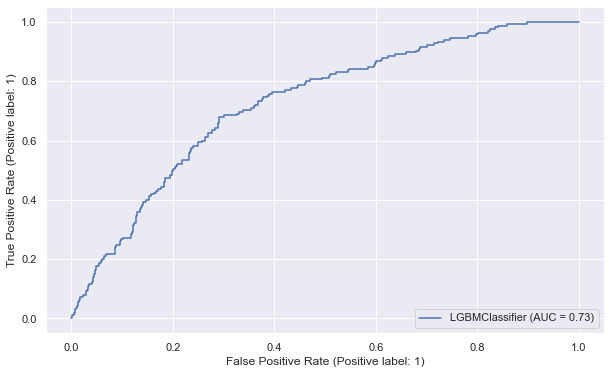

In [80]:
sns.set()
plt.rc('figure', figsize=(10, 6))
plot_roc_curve(best_model, xtest2, y_test)

C:\Users\marie\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


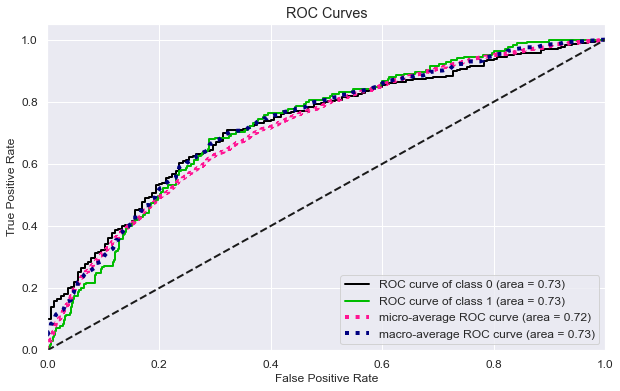

In [81]:
import scikitplot as skplt
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.show()

In [82]:
cm_lgbm = confusion_matrix(y_test, y_pred, labels=[1, 0])
tp, fn, fp, tn = cm_lgbm.ravel()

In [83]:
cm_lgbm_df = pd.DataFrame(cm_lgbm
                          , index=[['Actual', 'Actual'], ['def', 'nodef']]
                          , columns=[['Predicted', 'Predicted'], ['def', 'nodef']])

In [84]:
cm_lgbm_df

Predicted      
                   def nodef
Actual def         116    49
       nodef       624  1211

C:\Users\marie\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


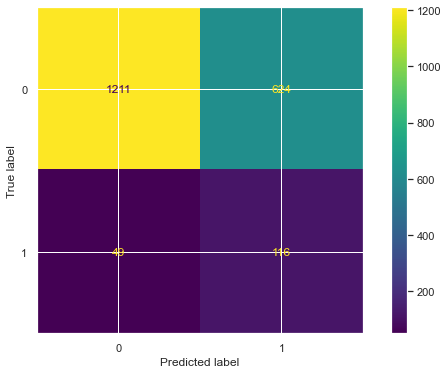

In [85]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(best_model, xtest2, y_test)  

In [86]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# precision, recall, fscore, support = precision_recall_fscore_support(yval, yval_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = tn / (tn + fp)
fscore = f1_score(y_test, y_pred)

In [87]:
# cm_metrics = pd.Series([precision, recall, fscore, support], index = ['precision', 'recall', 'fscore', 'support'])
cm_metrics = pd.Series([precision, recall, specificity, fscore], index = ['precision', 'recall', 'specificity', 'fscore'])
cm_metrics

precision      0.156757
recall         0.703030
specificity    0.659946
fscore         0.256354
dtype: float64

## Optimize threshold to maximise False Negative (1-recall)

In [88]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [89]:
def cust_predict_proba(pos_class_proba_array, thres=0.5):
    """This is a threshold function that convert an array of probabilities of belonging to class "1" into a array of labels 0 or 1 with respect to the threshold
    We will use this function to set up an optimal threshold that minimize false negative, unlike the default value of 0.5"""
    pos_class_proba_array = pd.Series(pos_class_proba_array)
    pos_class_proba_array = pos_class_proba_array.map(lambda x: 1 if x > thres else 0)
    return pos_class_proba_array.to_numpy()

In [90]:
# we will visually determine the probability threshold that maximize the custom metrics (i.e.that penalizes false negatives) 
# but do not sacrifice accuracy too much
scores = [] 
false_negatives_rates = [] 
false_positives_rates = []
precision_scores = []
f_scores = []
accuracy_scores = []
thresholds      = [0.95, 0.91, 0.86, 0.82, 0.77, 0.73, 0.68, 0.64, 0.59, 0.55, 0.5, 0.46, 
                   0.41, 0.37, 0.32, 0.28, 0.23, 0.19, 0.14, 0.1]

for thr in thresholds:
    cm_lgbm = confusion_matrix(y_test, cust_predict_proba(y_pred_proba[:,1], thres=thr), labels=[1, 0])
    tp, fn, fp, tn = cm_lgbm.ravel()
    #fn
    recall = tp / (tp + fn)
    false_negatives_rate = 1 - recall
    false_negatives_rates.append(false_negatives_rate)
    #fp
    false_positives_rate = fp / (tn + fp)
    false_positives_rates.append(false_positives_rate)
    # precision
    precision_score_ = tp / (tp + fp)
    precision_scores.append(precision_score_)
    #f_score
    f_score = (precision_score_*recall) / (precision_score_ + recall)
    f_scores.append(f_score)
    # accuracy
    accuracy_score_ = (tp + tn) / (tp + fn + fp + tn)
    accuracy_scores.append(accuracy_score_)
    # custom metrics
    scores.append(cust_metric(y_test, cust_predict_proba(y_pred_proba[:,1], thres=thr)))

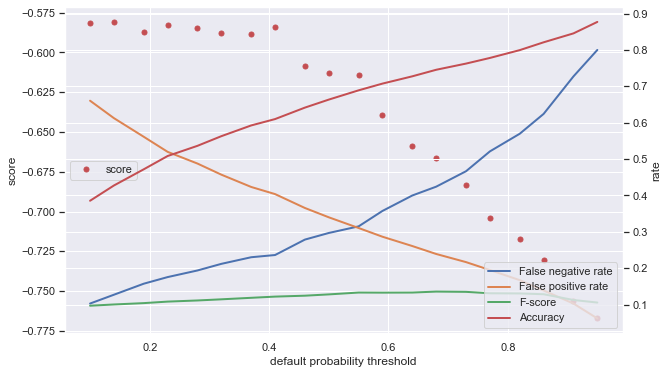

In [91]:

plt.rcParams.update({'lines.markersize'   :5,
                           'lines.linewidth'    :2})
fig, ax = plt.subplots()
ax.plot(thresholds, scores,'ro', label='score')
ax.set_ylabel("score")
ax.set_xlabel("default probability threshold")
plt.legend(loc='center left')
# creating second y axis
ax2 = ax.twinx()
ax2.plot(thresholds, false_negatives_rates, label='False negative rate')
ax2.plot(thresholds, false_positives_rates, label='False positive rate')
# ax2.plot(thresholds, precision_scores, label='Precision')
ax2.plot(thresholds, f_scores, label='F-score')
ax2.plot(thresholds, accuracy_scores, label='Accuracy')
ax2.set_ylabel("rate")
ax2.legend(loc='lower right')

It is up to the client to decide which threshold is best considering the above lines.

Interpretation:

for a thr of 0.5: 30% of actual negative(no def) clients will be rejected 30% of actual positive(def) clients will be accepted Overall accuracy will be 65%
Reminder:The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

In [92]:
cm_lgbm = confusion_matrix(y_test, cust_predict_proba(y_pred_proba[:,1], thres=0.50), labels=[1, 0])
cm_lgbm_df = pd.DataFrame(cm_lgbm
                          , index=[['Actual', 'Actual'], ['def', 'nodef']]
                          , columns=[['Predicted', 'Predicted'], ['def', 'nodef']])
# confusion matrix in % of total applicants
round(cm_lgbm_df / len(y_pred_proba) * 100, 1)

Predicted      
                   def nodef
Actual def         5.8   2.4
       nodef      31.2  60.6

In [93]:
cm_lgbm = confusion_matrix(y_test, cust_predict_proba(y_pred_proba[:,1], thres=0.41), labels=[1, 0])
cm_lgbm_df = pd.DataFrame(cm_lgbm
                          , index=[['Actual', 'Actual'], ['def', 'nodef']]
                          , columns=[['Predicted', 'Predicted'], ['def', 'nodef']])
# confusion matrix in % of total applicants
round(cm_lgbm_df / len(y_pred_proba) * 100, 1)

Predicted      
                   def nodef
Actual def         6.3   2.0
       nodef      37.0  54.7

In [94]:
# nous prédisons la classe avec le seuil optimal de 0.65
y_pred_opti = cust_predict_proba(y_pred_proba[:,1], thres=0.41)
print("recall :", recall_score(y_test, y_pred_opti))
print("accuracy :", accuracy_score(y_test, y_pred_opti))
print("AUC :", roc_auc_score(y_test, y_pred_proba[:,1]))
print("custom :",cust_metric(y_test, y_pred_opti))

recall : 0.7636363636363637
accuracy : 0.61
AUC : 0.7271373131863595
custom : -0.583688790308821


## Features importance best model

In [95]:
feature_importance = feature_importances.head(20)

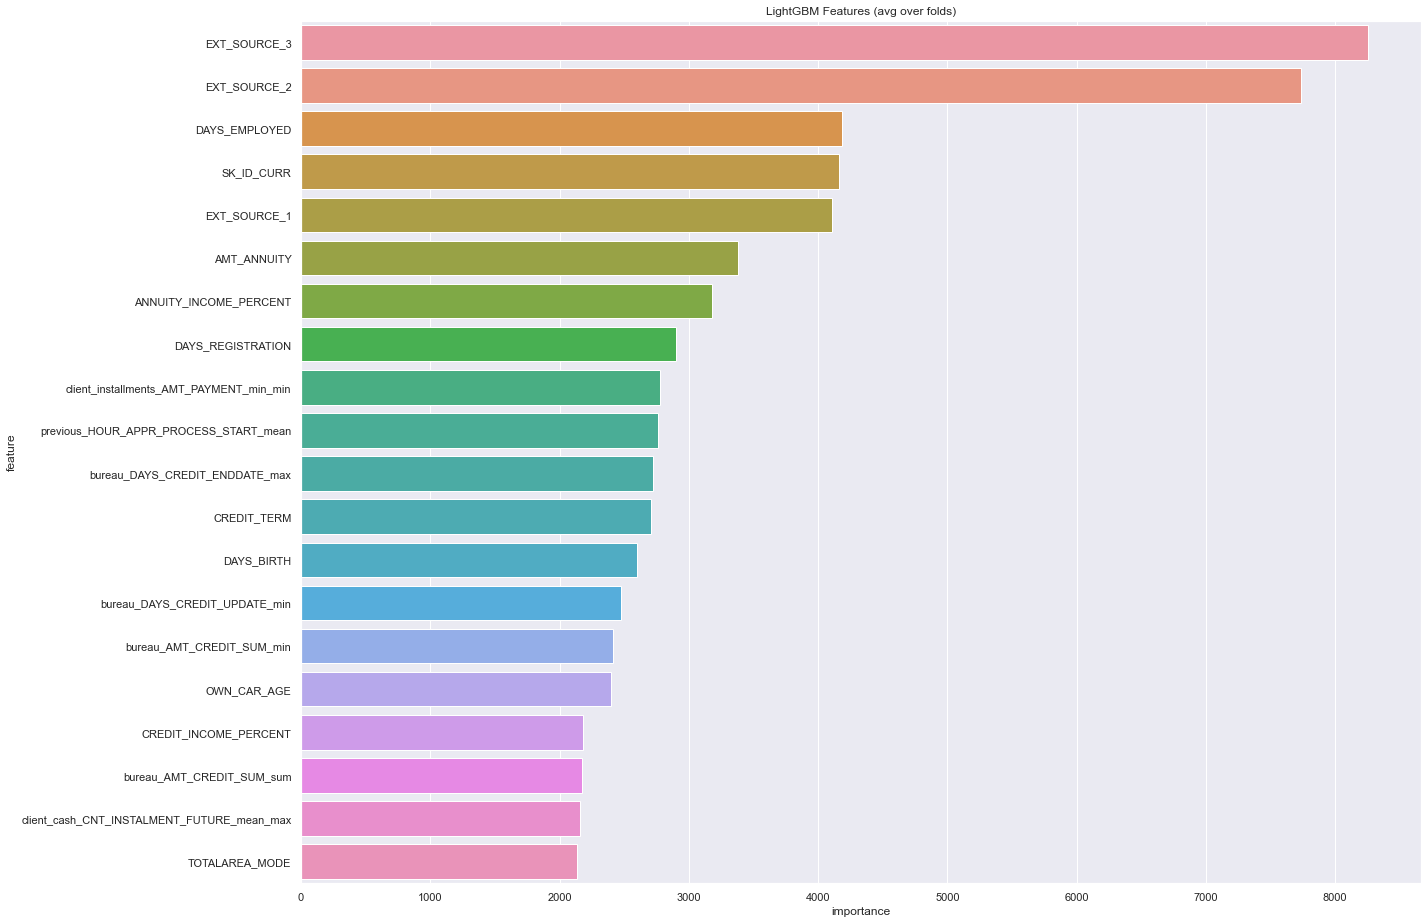

In [96]:
# collecting features importance of the selected columns in a Dataframe
#feature_imp = pd.DataFrame(zip(best_pipe.named_steps["LBMC"].feature_importances_, X.iloc[:,selected_columns].columns), columns=['Value','Feature'])
plt.figure(figsize=(20, 13))
# and plotting it
sns.barplot(x="importance", y="feature", data=feature_importance.sort_values(by="importance", ascending=False).head(50))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

# SHAP

In [97]:
!pip install shap

In [98]:
import shap

In [99]:
# load JS visualization code to notebook
shap.initjs()

In [100]:
explainer = shap.TreeExplainer(best_model) # data is required if you're using interventional feature_perturbation
# or
# expainer = shap.Explainer(model, masker=X_) # masker required
# calculate shap with shap_values method

# if the below line is run in a different cell, I get an error of reshaping, no solution found
# the explainer is fitted using the model itself fitted on the preprocessed (undersampled data)
# but we want the shap values for all clients, not just the undersampled
shapvs = explainer.shap_values(xtrain2, check_additivity=True) # check should be default

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [101]:
shapvs[1].shape

(1316, 1712)

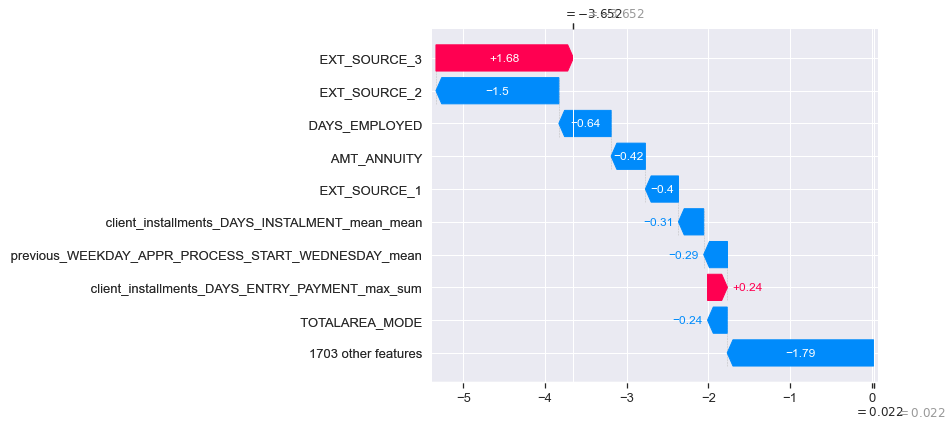

In [102]:
# use the following function for waterfall: display contribution for one client
# tree explainer with LGBM returns the shap values of both class 0 and 1 : list of two arrays of shape (44686, 50)
# we are interested in explaining the contributions to default predictions so our shap values will be shapvs[1]
# more info here https://github.com/slundberg/shap/issues/837
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shapvs[1][3], features=xtrain2.iloc[3].values, feature_names=xtrain2.columns) 

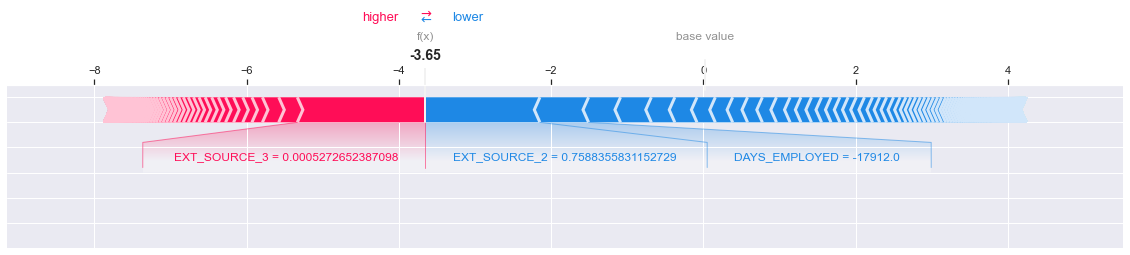

In [103]:
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value[1], shapvs[1][3], features=xtrain2.iloc[3], feature_names=xtrain2.columns, matplotlib=True)

In [104]:
xtrain2.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
count,1316.000000,1316.000000,1316.000000,1316.000000,1316.000000,1.316000e+03,1.316000e+03,1316.000000,1.316000e+03,1316.000000,...,1253.000000,1253.000000,1.253000e+03,1253.000000,1.253000e+03,1253.000000,1.253000e+03,1.253000e+03,1.253000e+03,1.253000e+03
mean,277238.541033,0.078267,0.331307,0.690729,0.449088,2.535885e+05,5.826810e+05,26831.092705,5.158748e+05,0.021074,...,39.826816,8466.093814,2.392066e+04,4519.738974,2.573960e+05,39.826816,2.500460e+05,3.923420e+05,8.987916e+04,1.529511e+07
std,103000.463553,0.268694,0.470862,0.462369,0.735617,3.221699e+06,3.657171e+05,13237.326952,3.319059e+05,0.013587,...,40.532788,11031.684808,7.161390e+04,9263.111034,3.569788e+05,40.532788,3.108601e+05,4.989858e+05,1.351825e+05,3.305333e+07
min,100333.000000,0.000000,0.000000,0.000000,0.000000,3.735000e+04,4.500000e+04,4324.500000,4.500000e+04,0.001276,...,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,7.301745e+03,7.301745e+03,1.441260e+03,7.301745e+03
25%,189371.500000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.762775e+05,17152.875000,2.385000e+05,0.010147,...,12.000000,2677.500000,5.835825e+03,31.500000,5.413239e+04,12.000000,7.075230e+04,8.884161e+04,2.804693e+04,1.009422e+06
50%,275099.000000,0.000000,0.000000,1.000000,0.000000,1.440000e+05,5.212800e+05,25537.500000,4.500000e+05,0.019101,...,25.000000,5852.330600,1.165437e+04,1037.025000,1.295306e+05,25.000000,1.427599e+05,1.885939e+05,5.229036e+04,3.549426e+06
75%,367873.750000,0.000000,1.000000,1.000000,1.000000,2.025000e+05,7.882335e+05,33774.750000,6.750000e+05,0.028663,...,52.000000,10881.615000,2.282490e+04,6201.135000,3.010567e+05,52.000000,3.155267e+05,4.923195e+05,9.915898e+04,1.506396e+07
max,455632.000000,1.000000,1.000000,1.000000,4.000000,1.170000e+08,2.961000e+06,105511.500000,2.961000e+06,0.072508,...,249.000000,211265.950000,1.383574e+06,211265.950000,2.723040e+06,249.000000,4.704651e+06,5.294349e+06,1.723360e+06,5.264206e+08


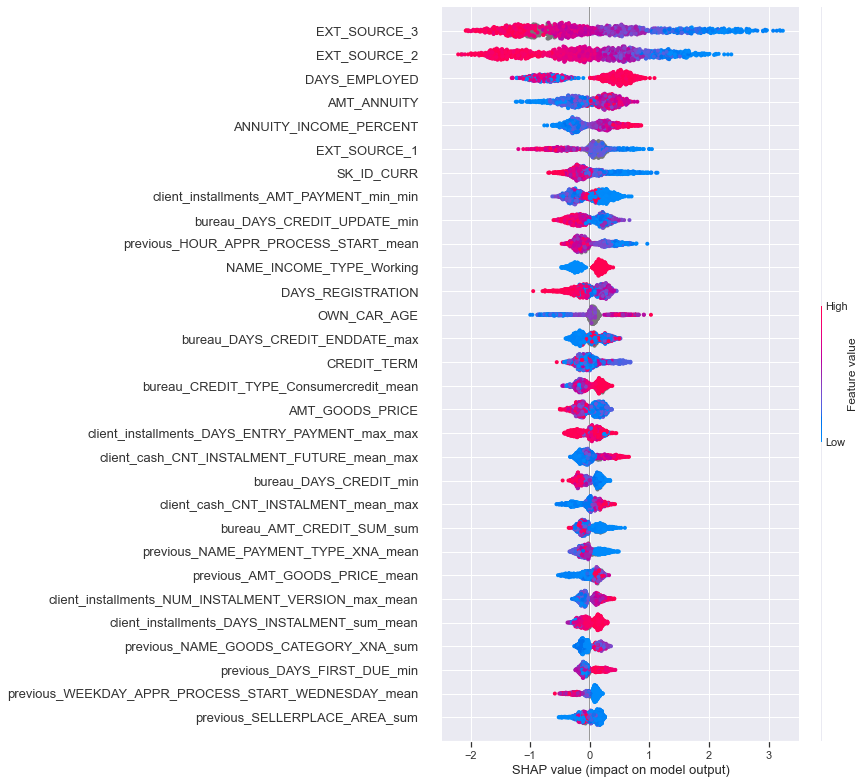

In [105]:
# summarize the effects of top features
shap.summary_plot(shapvs[1], xtrain2.values, xtrain2.columns, max_display=30)

Plus flag document 3 est faible (bleu), plus la proba de défaut est faible

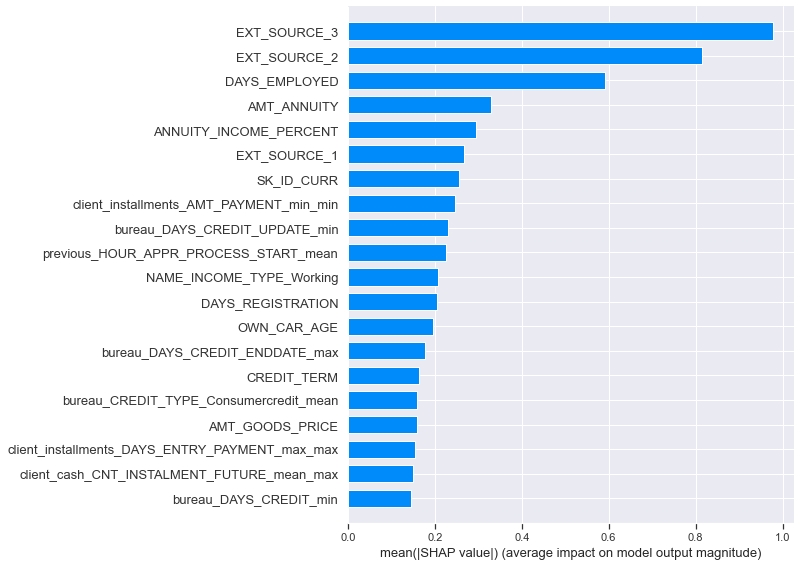

In [106]:
shap.summary_plot(shapvs[1], features=xtrain2.values, feature_names=xtrain2.columns, plot_type='bar')

# ENREGISTREMENT DU MODELE

In [107]:
import pickle
from pickle import *
filename = 'best_model.joblib'
pickle.dump(best_model, open(filename, 'wb'))

In [108]:
import joblib
# save the model to disk
filename = 'best_model.sav'
joblib.dump(best_model, filename)

['best_model.sav']

In [109]:
# test
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.predict_proba(pd.DataFrame(xtrain2.iloc[3]).T)
print(result)

[[0.97471151 0.02528849]]


# ENREGISTREMENT DE L'EXPLAINER

In [114]:
ex_filename = 'explainer.sav'
joblib.dump(explainer, filename=ex_filename)

['explainer.sav']

In [111]:
#test
ex2 = joblib.load(filename=ex_filename)
shap_values2 = ex2(xtrain2)
shap_values2

.values =
array([[[ 0.21419668, -0.21419668],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.00139854, -0.00139854],
        [ 0.00242824, -0.00242824],
        [ 0.00062724, -0.00062724]],

       [[-0.00655113,  0.00655113],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.00103123, -0.00103123],
        [-0.00481395,  0.00481395],
        [ 0.00061811, -0.00061811]],

       [[ 0.26675594, -0.26675594],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.00175794, -0.00175794],
        [-0.00245381,  0.00245381],
        [ 0.00214536, -0.00214536]],

       ...,

       [[-0.14825034,  0.14825034],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-0.001142  ,  0.001142  ],
        [ 0.00056302, -0.00056302],
        [ 0.00029897, -0.00029897]],

       [[ 0.16004101, -0.16004101],
        [ 0.     

# PREDICTIONS POUR LE DASHBOARD

In [112]:
sample_pred = xtrain2.copy()
sample_pred.insert(0, "PRED", best_model.predict(xtrain2))

In [113]:
sample_pred

,PRED,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
0,0,427510,0,0,1,0,180000.0,282690.0,15462.0,202500.0,...,59.0,13057.49900,30879.990,1123.740,770392.4400,59.0,387990.750,605090.060,36742.453,22891454.00
1,0,236317,0,0,1,0,139500.0,770292.0,32764.5,688500.0,...,40.0,3621.37040,20673.180,4.320,144854.8100,40.0,247359.380,269133.000,144712.250,9894375.00
2,0,274069,0,1,1,1,135000.0,296280.0,19930.5,225000.0,...,31.0,103.23000,103.230,103.230,3200.1301,31.0,197539.340,197539.340,197539.340,6123719.50
3,0,401620,0,0,1,0,157500.0,585000.0,17235.0,585000.0,...,32.0,39.96000,39.960,39.960,1278.7200,32.0,38238.970,60158.203,23241.600,1223647.00
4,0,330684,0,1,1,1,180000.0,835299.0,51102.0,774000.0,...,37.0,3530.07000,3530.070,3530.070,130612.5900,37.0,438813.060,438813.060,438813.060,16236083.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,1,139430,0,0,1,1,67500.0,66222.0,7258.5,58500.0,...,6.0,2237.94000,2237.940,2237.940,13427.6400,6.0,22717.215,22717.215,22717.215,136303.28
1312,1,454888,0,0,0,1,67500.0,592560.0,31023.0,450000.0,...,5.0,10069.42500,10069.425,10069.425,50347.1250,5.0,60207.883,60207.883,60207.883,301039.40
1313,1,249855,0,0,1,0,193500.0,495000.0,19309.5,495000.0,...,166.0,538.74866,2654.685,12.735,89432.2800,166.0,71395.836,157050.000,15517.080,11851709.00
1314,1,345102,0,1,0,0,126000.0,942300.0,30528.0,675000.0,...,94.0,0.00000,0.000,0.000,0.0000,94.0,311759.200,311759.200,311759.200,29305364.00


In [115]:
sample_pred.to_csv("C:\\Users\\marie\\OPC\\P7/sample_pred.csv")